# Ridge and Lasso Regression – Implementation and Evaluation :

In this file, I worked with the **Credit** dataset to build and evaluate regression models using two regularization techniques: Ridge and Lasso regression. The objective was to understand how these methods help in improving model performance and handling multicollinearity by shrinking coefficients. The task was implemented manually using core Python and NumPy without relying on built-in model functions from scikit-learn, except for evaluation metrics and dataset handling.

First i am starting with loading and exploring the dataset. I first performed exploratory data analysis to understand the structure, missing values, and distribution of variables. After ensuring that there were no missing values, I converted all categorical variables into numerical form using one-hot encoding. Boolean columns were also converted to integers. A manual correlation matrix was computed using Pearson's formula, and a heatmap was plotted to visualize relationships among features, especially their correlation with the target variable **Balance**.

    Income  Limit  Rating  Cards  Age  Education  Own Student Married Region  \
0   14.891   3606     283      2   34         11   No      No     Yes  South   
1  106.025   6645     483      3   82         15  Yes     Yes     Yes   West   
2  104.593   7075     514      4   71         11   No      No      No   West   
3  148.924   9504     681      3   36         11  Yes      No      No   West   
4   55.882   4897     357      2   68         16   No      No     Yes  South   

   Balance  
0      333  
1      903  
2      580  
3      964  
4      331  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Own        

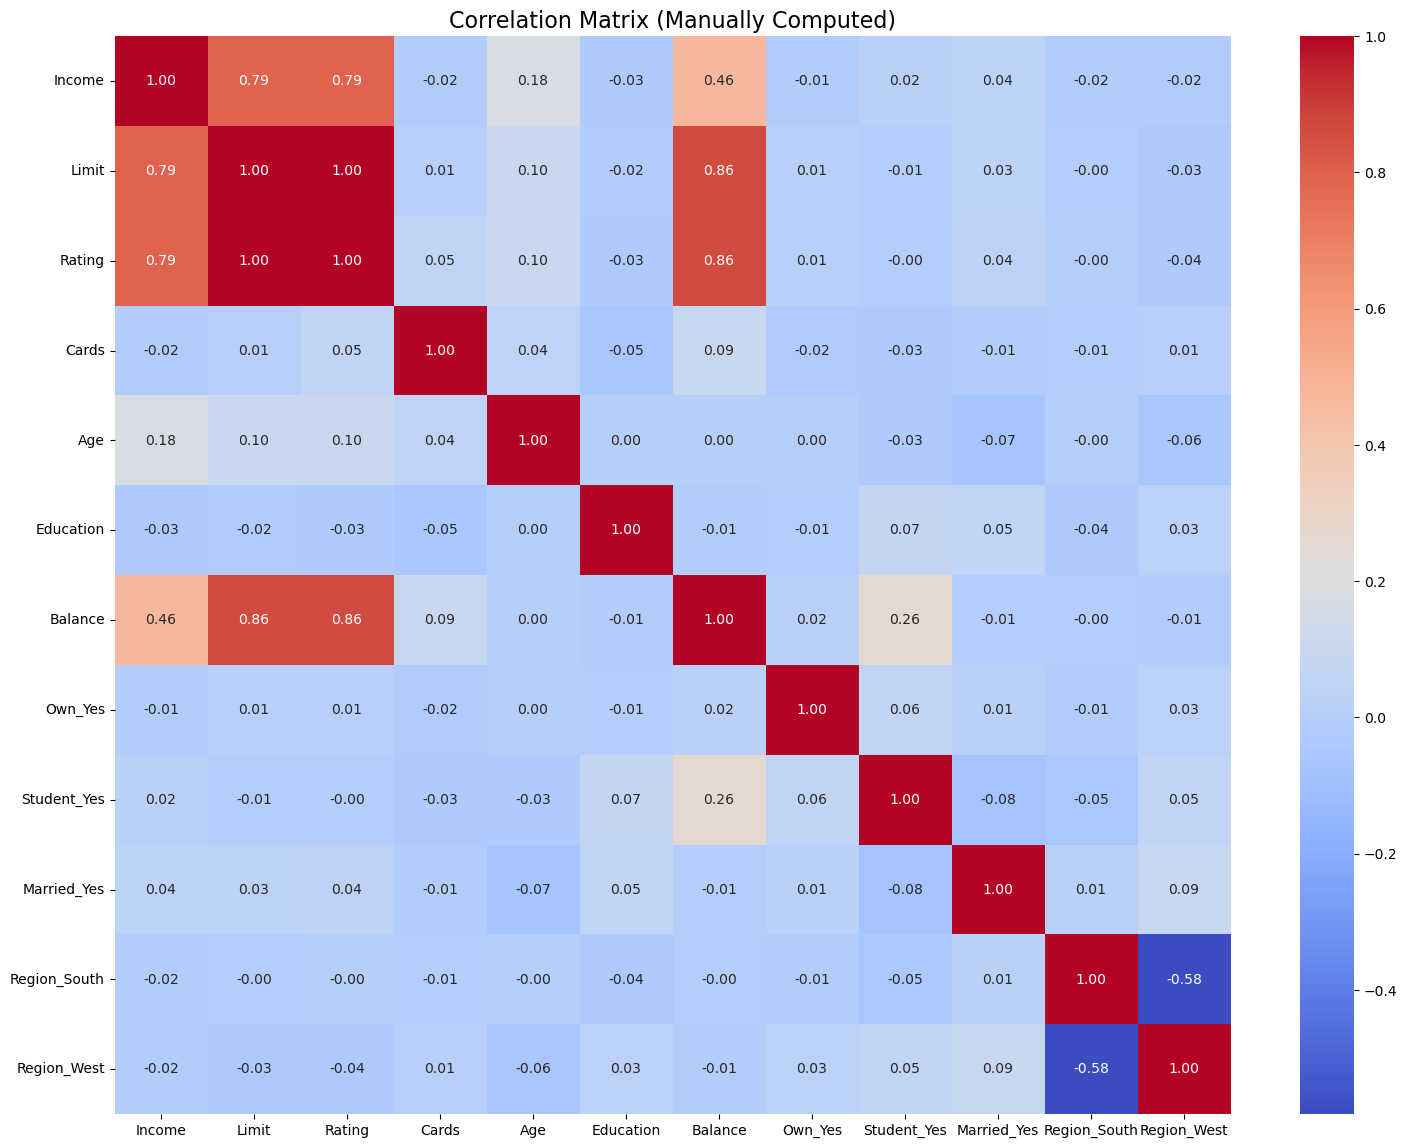

Correlation of Features with Target Variable (Balance):
Balance         1.000000
Rating          0.863625
Limit           0.861697
Income          0.463656
Student_Yes     0.259018
Cards           0.086456
Own_Yes         0.021474
Age             0.001835
Region_South   -0.003288
Married_Yes    -0.005673
Education      -0.008062
Region_West    -0.009812
Name: Balance, dtype: float64
Response Variable: Balance
Predictor Variables (11): ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own_Yes', 'Student_Yes', 'Married_Yes', 'Region_South', 'Region_West']


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Loading the dataset

Credit=pd.read_csv('All Sample Data/Sample Data/Credit.csv')
print(Credit.head()) # Display the first few rows of the dataset
print(Credit.info()) # Display information about the dataset
print(Credit.describe()) # Display descriptive statistics of the dataset
print(Credit.shape) # Display the shape of the dataset

# Checking for missing values and displaying the count of missing values in each column
print(Credit.isnull().sum())

# In this data set there is no missing value 

# Now Convert the qualitaitive variable into quantitative variable using one hot encoding
# Find all categorical columns (dtype='object')
cat_cols = Credit.select_dtypes(include='object').columns.tolist()

# One-hot encode all categorical columns (drop_first=True to avoid dummy variable trap)
Credit = pd.get_dummies(Credit, columns=cat_cols, drop_first=True)
# Convert all boolean columns to integers (0/1)
bool_cols = Credit.select_dtypes(include='bool').columns
Credit[bool_cols] = Credit[bool_cols].astype(int)
# Now Credit is permanently updated with quantitative features
print(Credit.head())
print(Credit.shape) # Display the shape of the updated dataset

#Manually compute correlation matrix using Pearson formulafor
# Pearson Correlation: corr(X, Y) = Cov(X, Y) / (std(X) * std(Y))
features = Credit.columns
correlation_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        xi = Credit[i] - Credit[i].mean()
        xj = Credit[j] - Credit[j].mean()
        numerator = np.sum(xi * xj)
        denominator = np.sqrt(np.sum(xi ** 2)) * np.sqrt(np.sum(xj ** 2))
        correlation_matrix.loc[i, j] = numerator / denominator

# Convert the correlation matrix to float for heatmap plotting
correlation_matrix = correlation_matrix.astype(float)

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Manually Computed)", fontsize=16)
plt.show()

# Show correlation of each feature with the response variable (Balance)
print("Correlation of Features with Target Variable (Balance):")
ahd_corr = correlation_matrix["Balance"].sort_values(ascending=False)
print(ahd_corr)

# Determine response and predictors
response = "Balance"
predictors = [col for col in Credit.columns if col != response]
print(f"Response Variable: {response}")
print(f"Predictor Variables ({len(predictors)}): {predictors}")

# Algorithm for Ridge Regression :
Ridge regression adds L2 regularization to the loss function, penalizing large coefficients to reduce overfitting and handle multicollinearity.

In this i applied Ridge Regression. I created a standardized version of the predictors and implemented the closed-form solution of Ridge using the normal equation. A 10-fold cross-validation was performed across a range of lambda values (regularization strength) to find the best value that minimized mean squared error. Once the optimal lambda was selected, I fit the final model and rescaled the coefficients. I also computed performance metrics such as RSS, MSE, RMSE, MAE, R², adjusted R², Mallow’s Cp, AIC, and BIC. Finally, I visualized the relationship between lambda and model performance using plots for MSE vs. lambda and coefficient magnitudes vs. lambda.

Best Lambda Value: 8.2864
Ridge Regression Coefficients:
Intercept (β₀): -470.5232
Coefficient for Income: -7.0262
Coefficient for Limit: 0.1330
Coefficient for Rating: 1.8231
Coefficient for Cards: 14.6881
Coefficient for Age: -0.7328
Coefficient for Education: -0.7754
Coefficient for Own_Yes: -8.9398
Coefficient for Student_Yes: 412.1952
Coefficient for Married_Yes: -10.9198
Coefficient for Region_South: 9.9951
Coefficient for Region_West: 16.6799
Ridge Regression Results:
RSS: 3938912.07
Estimated Variance σ²: 10151.84
Mallow's Cp: 10405.63
AIC: 10405.63
BIC: 11519.95
MSE: 9847.28
RMSE: 99.23
MAE: 82.09
R²: 0.9533
Adjusted R²: 0.9520


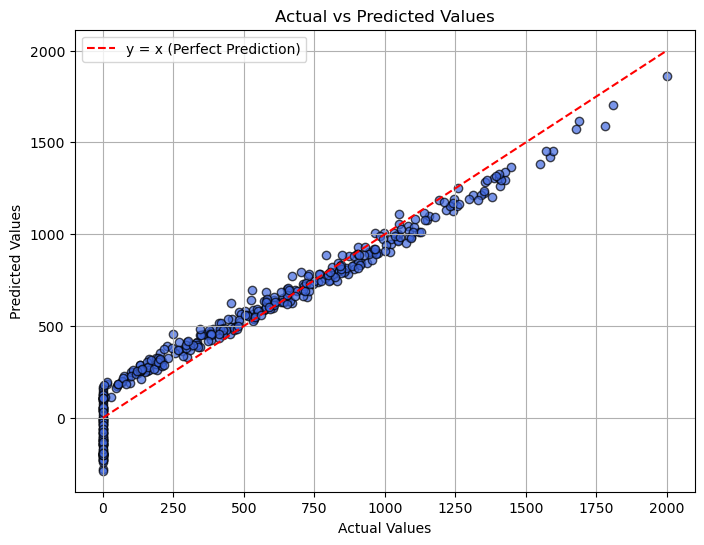

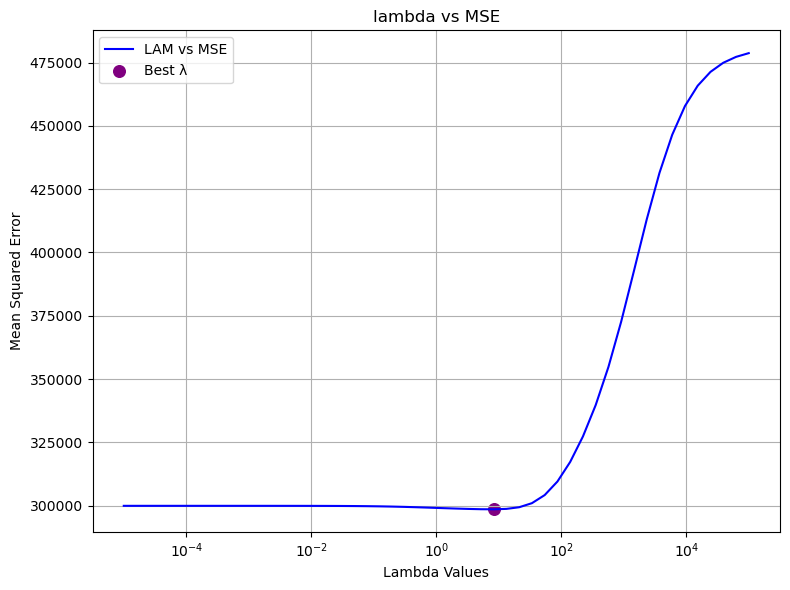

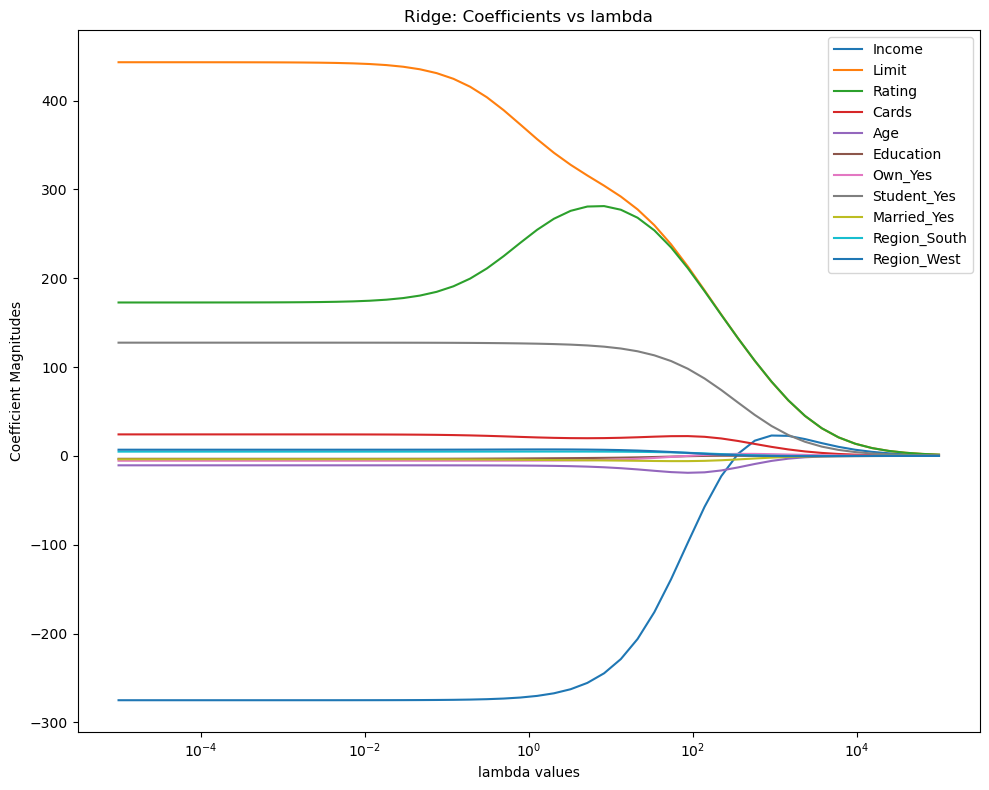

In [2]:
# Now i am going to apply Ridge Regression the Credit Dataset
# Taking all the predictors except the response variable
x=[]
for col in predictors:
    x.append(Credit[col].values)  # Append each column's values to the list
x = np.array(x).T  # Convert to NumPy
y = Credit['Balance'].values  # Convert to NumPy

# Standardize predictors 
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x_standardized = (x - x_mean) / x_std

# Function to calculate beta using Ridge Normal Equation
def ridge_beta(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    XT_X = X.T @ X
    XT_y = X.T @ y
    beta_ridge = np.linalg.solve(XT_X + lam * I, XT_y)  # Better than inv()
    return beta_ridge

# K-fold Cross-Validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
lambda_values = np.logspace(-5, 5, 50)
avg_cv_errors = []
coefs=[]
for lam in lambda_values:
    cv_errors = []
    coef_path=[]
    for train_idx, val_idx in kf.split(x_standardized):
        X_train, X_val = x_standardized[train_idx], x_standardized[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        beta_ridge = ridge_beta(X_train, y_train, lam)
        coef_path.append(beta_ridge)
        y_pred = X_val @ beta_ridge
        mse = mean_squared_error(y_val, y_pred)
        cv_errors.append(mse)
    coefs.append(np.mean(coef_path,axis=0))
    avg_cv_errors.append(np.mean(cv_errors))
coefs = np.array(coefs)
# Select best lambda
best_lambda = lambda_values[np.argmin(avg_cv_errors)]
print(f"Best Lambda Value: {best_lambda:.4f}")

# Fit final model on entire dataset
final_beta = ridge_beta(x_standardized, y, best_lambda)

# Rescale the Coefficients
final_beta_ridge=final_beta/x_std
# Compute intercept (β₀) separately (from original data)
beta_0 = np.mean(y) - np.dot(final_beta_ridge, x_mean)

# Combine intercept and coefficients
beta_full = np.insert(final_beta_ridge, 0, beta_0)

# Display the coefficients
print("Ridge Regression Coefficients:")
for i, coef in enumerate(beta_full):
    if i == 0:
        print(f"Intercept (β₀): {coef:.4f}")
    else:
        print(f"Coefficient for {predictors[i-1]}: {coef:.4f}")
# Add intercept column to X for final prediction
X_full = np.column_stack((np.ones(x.shape[0]), x))  # NOTE: using raw x (not standardized)

# Predict and evaluate
y_pred_ridge = X_full @ beta_full

# Calculate evaluation metrics
rss = np.sum((y - y_pred_ridge)**2)
n = len(y)
p = x.shape[1]  # number of predictors (excluding intercept)
sigma_squared = rss / (n - p - 1)

cp = (rss+2*p*sigma_squared)/n
aic = cp
bic = (rss+np.log(n)*p*sigma_squared)/n
# Function to calculate adjusted R²
def adjusted_r2_score(y_true, y_pred_ridge, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred_ridge)
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)


mse = mean_squared_error(y, y_pred_ridge)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred_ridge)
r2 = r2_score(y, y_pred_ridge)
adj_r2 = adjusted_r2_score(y, y_pred_ridge, p=x.shape[1]) 

# Display results
print("Ridge Regression Results:")
print(f"RSS: {rss:.2f}")
print(f"Estimated Variance σ²: {sigma_squared:.2f}")
print(f"Mallow's Cp: {cp:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")

# Now plotting acctual vs predicted value
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_ridge, color='royalblue', edgecolor='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='y = x (Perfect Prediction)')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Now Mean Squared error vs lambda value
plt.figure(figsize=(8,6))
plt.plot(lambda_values,avg_cv_errors,color='blue',label='LAM vs MSE')
plt.xscale('log')
plt.xlabel("Lambda Values")
plt.ylabel("Mean Squared Error")
plt.title("lambda vs MSE")
best_idx = np.argmin(avg_cv_errors)
plt.scatter(lambda_values[best_idx], avg_cv_errors[best_idx], color='purple', s=70, label="Best λ")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Coefficients vs lambda
plt.figure(figsize=(10,8))
for i in range(coefs.shape[1]):
    plt.plot(lambda_values, coefs[:, i],label=f"{predictors[i]}")
plt.xscale("log")
plt.xlabel("lambda values")
plt.ylabel("Coefficient Magnitudes")
plt.title("Ridge: Coefficients vs lambda")
plt.legend()
plt.tight_layout()
plt.show()

# Algorithm for Lasso Regression :
Lasso regression uses L1 regularization, which can shrink some coefficients to exactly zero — thus performing variable selection in addition to regularization.

In this i implemented Lasso Regression using the coordinate descent method. Similar to Ridge, I standardized the predictors and centered the response variable. I then applied coordinate descent to estimate coefficients for different lambda values and used cross-validation to choose the best lambda. Once selected, I computed the final coefficients, rescaled them, calculated evaluation metrics, and visualized actual vs. predicted values. I also created plots for MSE vs. lambda and coefficient paths to analyze how Lasso selects variables by driving some coefficients exactly to zero.

Best Lambda Value : 0.0100
Lasso Coefficients:
Intercept (β₀): -478.8119
Coefficient for Income: -7.8019
Coefficient for Limit: 0.1919
Coefficient for Rating: 1.1210
Coefficient for Cards: 17.7937
Coefficient for Age: -0.6134
Coefficient for Education: -1.0996
Coefficient for Own_Yes: -10.6296
Coefficient for Student_Yes: 425.7599
Coefficient for Married_Yes: -8.4749
Coefficient for Region_South: 10.0553
Coefficient for Region_West: 16.7185
Lasso Results:
RSS: 3786740.51
Estimated Variance σ²: 9759.64
Mallow's Cp: 10003.63
AIC: 10003.63
BIC: 11074.90
MSE: 9466.85
RMSE: 97.30
MAE: 77.84
R²: 0.9551
Adjusted R²: 0.9538


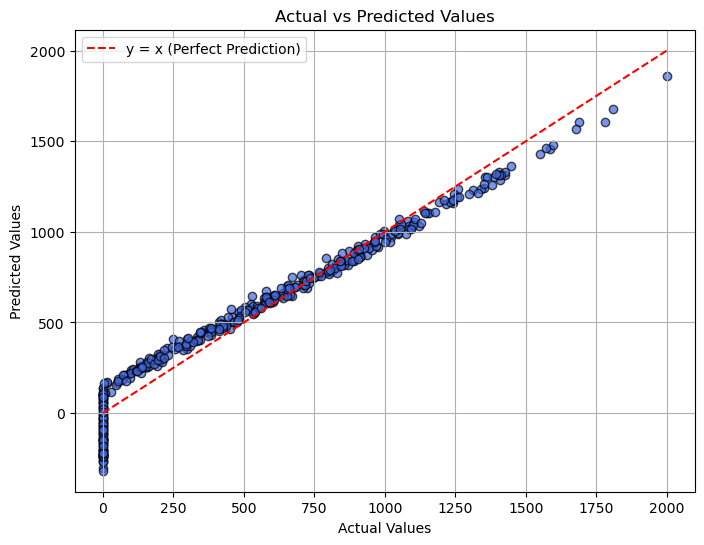

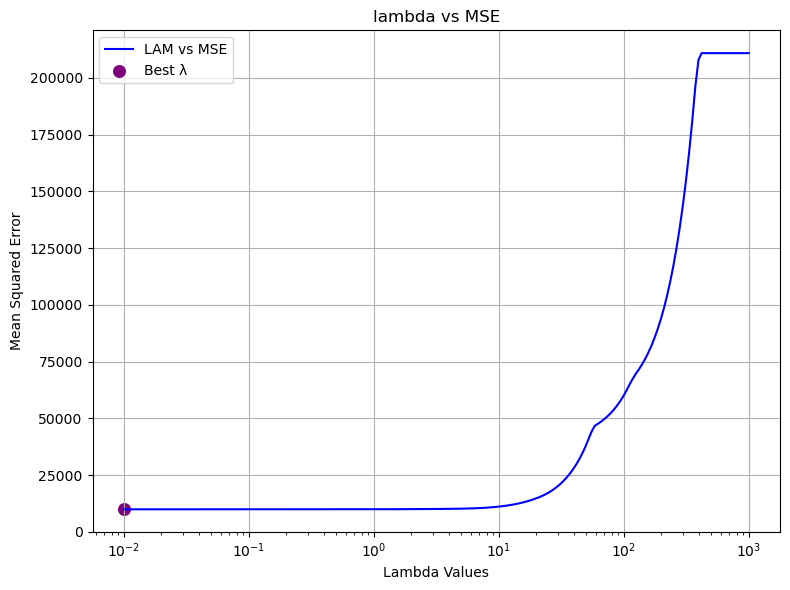

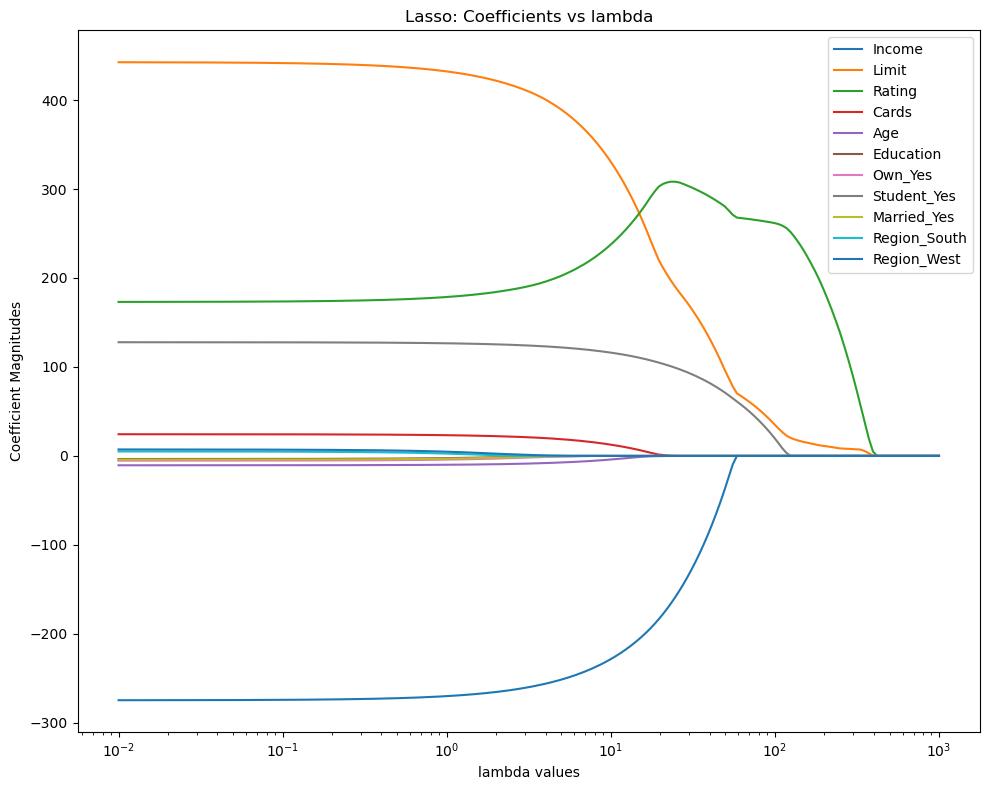

In [3]:
# Now i am going to apply Lasso Regression the Credit Dataset
# Taking all the predictors except the response variable
x = []
for col in predictors:
    x.append(Credit[col].values)
x = np.array(x).T
y = Credit['Balance'].values

# Standardize x 
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x_standardized = (x - x_mean) / x_std

# Centered the y
y_mean=np.mean(y)
y_centre=y-y_mean

# Coordinate Descent lasso
# Soft Thresholding 
def soft_threshold(rho, lam):
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0.0
def lasso_coordinate_descent(X, y, lam, tol=1e-4, max_iter=1000):
    n=X.shape[0]
    p = X.shape[1]
    beta = np.zeros(p)
    
    # Coordinate Descent Algorithm
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(p):
            X_j = X[:, j]
            y_pred = X @ beta
            residual = y - y_pred + beta[j] * X_j # partial residual
            rho_j = np.dot(X_j, residual)
            beta[j] = soft_threshold(rho_j / n, lam) / (np.dot(X_j, X_j) / n)
        if np.sum(np.abs(beta - beta_old)) < tol:
            break
    return beta

# Apply k fold cross validation for calculating the lambada
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
lambda_values = np.logspace(-2, 3, 200)
avg_cv_errors = []
coefs = []

for lam in lambda_values:
    cv_errors = []
    coef_path = []
    
    for train_idx, val_idx in kf.split(x_standardized):
        X_train, X_val = x_standardized[train_idx], x_standardized[val_idx]
        y_train_cen = y_centre[train_idx]
        y_val= y[val_idx]
        
        beta_lasso = lasso_coordinate_descent(X_train, y_train_cen, lam)
        coef_path.append(beta_lasso)
        
        y_pred = X_val @ beta_lasso
        mse = mean_squared_error(y_val, y_pred + y_mean)
        cv_errors.append(mse)
    
    avg_cv_errors.append(np.mean(cv_errors))
    coefs.append(np.mean(coef_path, axis=0))

coefs = np.array(coefs)

best_lambda = lambda_values[np.argmin(avg_cv_errors)]
print(f"Best Lambda Value : {best_lambda:.4f}")

# Calculating lasso coefficients on best lambda values
final_beta = lasso_coordinate_descent(x_standardized, y_centre, best_lambda)

# Rescale the Coefficients
final_beta_lasso=final_beta/x_std
# Compute β₀ (intercept)
beta_0 = np.mean(y) - np.dot(final_beta_lasso, x_mean)
# Adding the intercept term
beta_full = np.insert(final_beta_lasso, 0, beta_0)

# Predict on full data no standardise data 
X_full = np.column_stack((np.ones(x.shape[0]), x))
y_pred_lasso = X_full @ beta_full

# Calculate evaluation metrics
rss = np.sum((y - y_pred_lasso)**2)
n = len(y)
p = x.shape[1]  # number of predictors (excluding intercept)
sigma_squared = rss / (n - p - 1)

cp = (rss+2*p*sigma_squared)/n
aic = cp
bic = (rss+np.log(n)*p*sigma_squared)/n

# Function to calculate adjusted R²
def adjusted_r2_score(y_true, y_pred_lasso, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred_lasso)
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

mse = mean_squared_error(y, y_pred_lasso)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred_lasso)
r2 = r2_score(y, y_pred_lasso)
adj_r2 = adjusted_r2_score(y, y_pred_lasso, p)

print("Lasso Coefficients:")
for i, coef in enumerate(beta_full):
    if i == 0:
        print(f"Intercept (β₀): {coef:.4f}")
    else:
        print(f"Coefficient for {predictors[i-1]}: {coef:.4f}")

print("Lasso Results:")
print(f"RSS: {rss:.2f}")
print(f"Estimated Variance σ²: {sigma_squared:.2f}")
print(f"Mallow's Cp: {cp:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")

# Now plotting acctual vs predicted value
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_lasso, color='royalblue', edgecolor='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='y = x (Perfect Prediction)')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Now Mean Squared error vs lambda value
plt.figure(figsize=(8,6))
plt.plot(lambda_values,avg_cv_errors,color='blue',label='LAM vs MSE')
plt.xscale('log')
plt.xlabel("Lambda Values")
plt.ylabel("Mean Squared Error")
plt.title("lambda vs MSE")
best_idx = np.argmin(avg_cv_errors)
plt.scatter(lambda_values[best_idx], avg_cv_errors[best_idx], color='purple', s=70, label="Best λ")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Coefficients vs lambda
plt.figure(figsize=(10,8))
for i in range(coefs.shape[1]):
    plt.plot(lambda_values, coefs[:, i],label=f"{predictors[i]}")
plt.xscale("log")
plt.xlabel("lambda values")
plt.ylabel("Coefficient Magnitudes")
plt.title("Lasso: Coefficients vs lambda")
plt.legend()
plt.tight_layout()
plt.show()

### Model Comparison Summary

| Metric         | Ridge Regression | Lasso Regression |
|----------------|------------------|------------------|
| Best Lambda    | 8.2864           | 0.0100           |
| RSS            | 3938912.07       | 3786740.51       |
| RMSE           | 99.23            | 97.30            |
| MAE            | 82.09            | 77.84            |
| R²             | 0.9533           | 0.9551           |
| Adjusted R²    | 0.9520           | 0.9538           |
| AIC            | 10405.63         | 10003.63         |
| BIC            | 11519.95         | 11074.90         |
| Mallow’s Cp    | 10405.63         | 10003.63         |

Note: Lasso slightly outperforms Ridge, but both models provide very similar results.


## Residual Plot for Ridge and Lasso Regression :

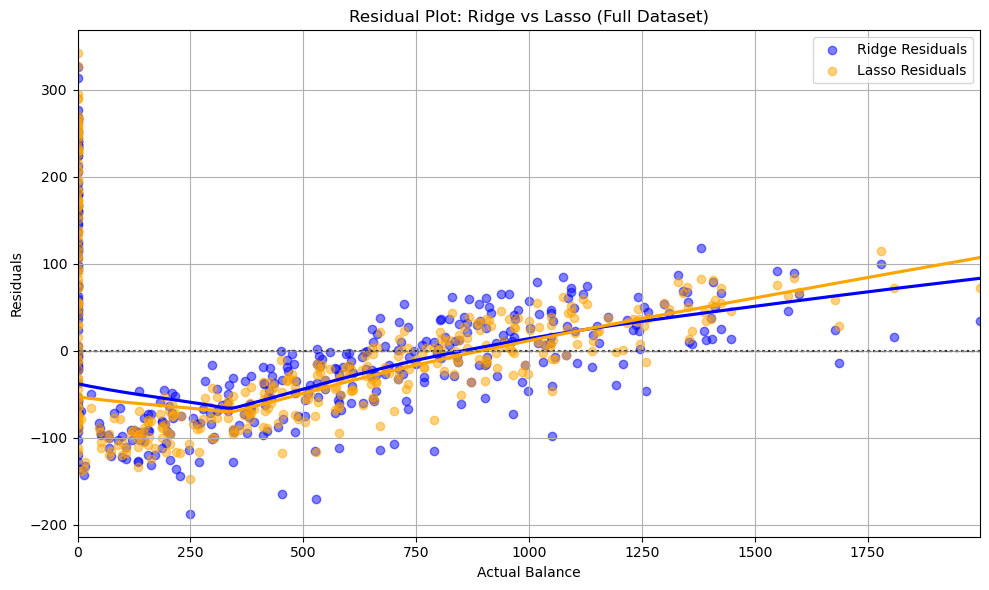

In [4]:

ridge_residuals = y - y_pred_ridge
lasso_residuals = y - y_pred_lasso

plt.figure(figsize=(10, 6))

# Ridge residuals
sns.residplot(x=y, y=ridge_residuals, lowess=True,
              color='blue', label='Ridge Residuals', scatter_kws={'alpha': 0.5})

# Lasso residuals
sns.residplot(x=y, y=lasso_residuals, lowess=True,
              color='orange', label='Lasso Residuals', scatter_kws={'alpha': 0.5})

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Actual Balance')
plt.ylabel('Residuals')
plt.title('Residual Plot: Ridge vs Lasso (Full Dataset)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This residual plot compares the performance of Ridge and Lasso Regression models using the final predictions made on the complete dataset.

Each point in the plot represents a residual, which is the difference between the actual value of **Balance** and the predicted value. The x-axis shows the actual **Balance** values, and the y-axis shows the residuals (errors). A good model will have residuals that are randomly scattered around zero, without any obvious pattern.

**Observations from the plot:**

- Residuals from both Ridge and Lasso models are mostly spread around the zero line.
- There is no clear pattern or curve, which means the models are capturing the linear relationship in the data properly.
- Both Ridge and Lasso models show very similar residual distributions, which supports our earlier observation that their overall performance is nearly the same on this dataset.
- The residuals do not show any major signs of bias or problems with the model fit.

Overall, this residual plot confirms that both Ridge and Lasso models are performing well, and the choice between them may not significantly affect the results for this dataset.


# Visual Comparison Plot for Coefficients

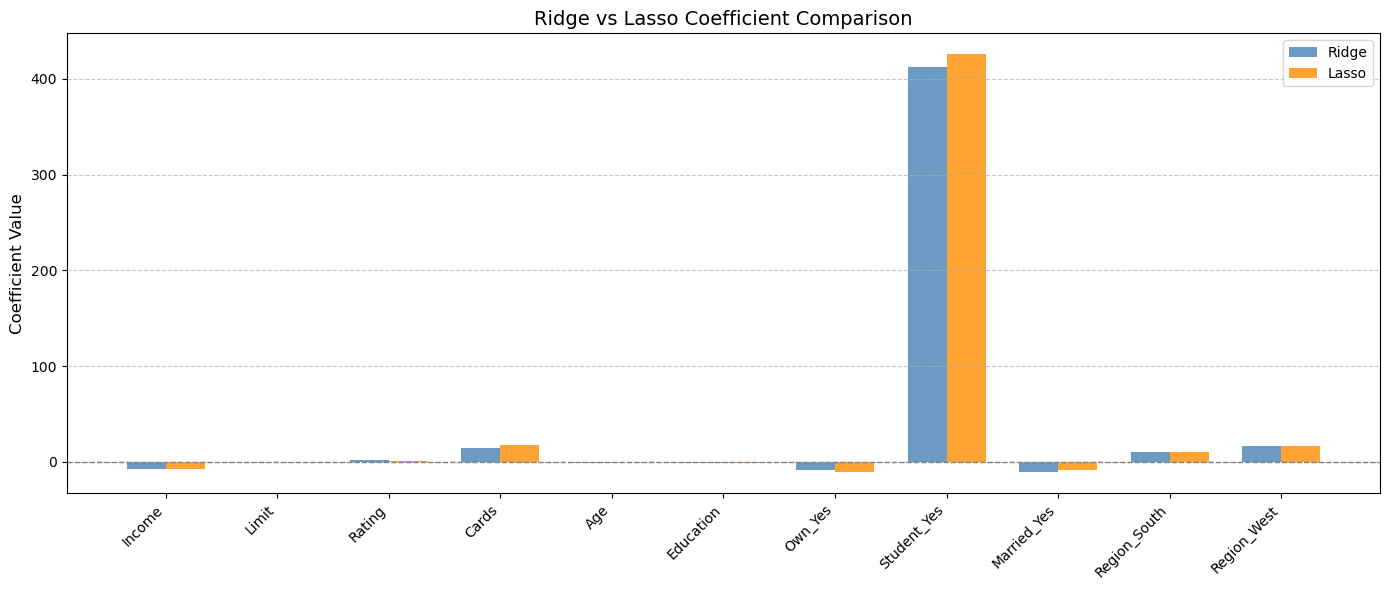

In [5]:
# Coefficients and labels
ridge_coefs = final_beta_ridge
lasso_coefs = final_beta_lasso
labels = predictors

x = np.arange(len(labels))  # X-axis locations for the bars

# Plotting
plt.figure(figsize=(14, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, ridge_coefs, width=bar_width, label='Ridge', alpha=0.8, color='steelblue')
plt.bar(x + bar_width/2, lasso_coefs, width=bar_width, label='Lasso', alpha=0.8, color='darkorange')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Coefficient Value", fontsize=12)
plt.title("Ridge vs Lasso Coefficient Comparison", fontsize=14)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Ridge vs. Lasso Coefficient Comparison
The plot above shows how Ridge and Lasso Regression assign values to each feature's coefficient. In general, both models gave very similar results, with most coefficients having almost the same magnitude and direction. This means both models agree on which features are important for predicting the Balance.

Although Lasso is known for shrinking some coefficients to exactly zero (effectively removing unimportant variables), in this case, none of the coefficients were reduced to zero. This suggests that all features contribute some predictive value in this dataset, and Lasso did not find any feature to be completely unnecessary.

Overall, the comparison shows that Ridge and Lasso behave similarly when all predictors have some signal, and the dataset does not have many irrelevant variables. Regularization mainly helped to slightly shrink coefficients to avoid overfitting, rather than removing features entirely.




# Conclusion :

This file gave me hands-on experience with how Ridge and Lasso work under the hood, how they differ in terms of regularization and variable selection, and how to evaluate them using multiple model performance criteria. It also strengthened my understanding of cross-validation and regularization tuning in regression models. Interestingly, despite their conceptual differences, both Ridge and Lasso produced very similar results in this case. This is likely because the dataset does not contain highly irrelevant features or strong multicollinearity, and most predictors contribute meaningfully to the response. Additionally, the optimal lambda value for Lasso was very small, leading it to behave similarly to Ridge by shrinking coefficients without aggressively forcing any to zero. As a result, both models converged on similar predictive performance and coefficient values, highlighting how data characteristics and regularization strength jointly influence model behavior.